1_results_A_transect_figures.ipynb  
# Plot sections of geotraces cruises on Bern3D grid

**Notebook input:**
- runs (from modeldir):
  - CTRL
  - Px1_18Sv
  - Px1_9Sv
  - Pdyn_9Sv 
- seawater observations (from obsdir): 
  - Pad_Thd_IDP2021.txt (geotraces dissolved)
  - Pap_Thp_IDP2021.txt (geotraces particle-bound)
  - Deng2018Pad_Thd_formatted_uBq_per_kg.csv
  - Ng2020Pad_Thd_formatted_dpm_per_1000kg.csv
  - Pavia2020Pad_Thd_formatted_uBq_per_kg.csv

**Notebook output (written to savedir):**
- a figure with model-data comparison of 1 cruise and 1 run (free to choose in settings)
- Fig. 5
- Fig. C1
- Fig. 11
- intermediate versions xxx_halfcropped.pdf and xxx_uncropped.pdf of these figures
- Atl_avg_p_sensitivity.pdf = Fig. 11 as Atlantic zonal average instead of along trajectories

**Notebook comments:**   
- This notebook makes the transect/section plots along trajectories. 
- In addition to the usual functions.py, additional plotting routines are used from plot_gruber.py, plot_profile.py, plot_helpers.py (still needed?) and plot_surface.py.
- This notebook also uses pdfCropMargins and pfdjam. 
   - pdfCropMargins can be installed via '$ pip3 install pdfCropMargins --user --upgrade'
   - instructions to install pdfjam are in markdown comments below (if needed; sometimes default installed)
- Fig. 5 and C1 can easily be plotted for another run than CTRL, by just changing the runname in the settings (at top of cell of respective plot).

# Set up notebook  

**Easiest:** load conda environment for which this notebook worked.  
**Just use environment.yml (present in this folder) and follow** https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file

In [2]:
from pathlib import Path         # Path objects to avoid inter-platform trouble in file paths
import platform

########## SET FILE PATHS ######################################

# KEEP THE Path() FUNCTION AND USE FORWARD SLASHES '/' ON EVERY OPERATING SYSTEM
savedir = Path('./figures/')      # folder for saving figures & other output; (empty) directory needed
obsdir = Path('./data/')          # obs. data is loaded from here
modeldir = Path('./modeloutput/') # model output is loaded from here

## OR define modeldir depending on which system you are working on:
# if platform.system() == "Darwin":   # on Mac (e.g. laptop)
#    modeldir = Path('~/Documents/PHD/Bern3D/results')
# elif platform.system() == "Linux":  # on linux (e.g. cluster)
#    modeldir = Path('/storage/climatestor/Bern3dLPX/scheen/b3d_results')
# else:
#    raise Exception("unknown system", platform.system())

#############################################

## CHECK FILEPATHS
# expand paths because np.loadtxt can't handle home directory ~
savedir = savedir.expanduser()
obsdir = obsdir.expanduser()
modeldir = modeldir.expanduser()
def check_dir(path):
    if not path.exists():
        raise Exception('File path ' + str(path) + ' does not exit. Correct or create first.')
check_dir(savedir)
check_dir(obsdir)
check_dir(modeldir)

## IMPORT PACKAGES
# first time install missing packages via $conda install numpy OR $pip3 install numpy (be consistent)
import numpy as np
import xarray as xr                            # $conda install -c anaconda -n cartopy xarray; needs some time
import pandas as pd
import importlib as imp                        # to import user-defined functions; renaming new name to name of deprecated package 'imp'
import math                                    # math.e or math.exp()
import xesmf as xe                             # regridding; install via conda-forge channel e.g. !conda install -c conda-forge xesmf -y

# plot-related packages:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace
import matplotlib.cm as cmp                    # colormaps
import cmcrameri.cm as cmcr                    # better colour maps (https://www.fabiocrameri.ch/colourmaps/); $conda install -c conda-forge cmcrameri
import cartopy.crs as ccrs
import seaborn as sns

## CHECK PYTHON VERSION
if 1/2 == 0:
    raise Exception("You are using python 2. Please use python 3 for a correct display of the figures.") 

## PLOT SETTINGS
# larger labels
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## PREPARE TRANSECT PLOTTING 
# (originally based on Nikki Gruber's idea to plot Atl+SO+Pac together)
from plot_surface import Surface
from plot_gruber import Gruber
from plot_profile import Profile
# needed for combining figures with pdfjam:
import os
from matplotlib.backends.backend_pdf import PdfPages
# needed for cropping white boundary:
from pdfCropMargins import crop  # installed via 'pip3 install pdfCropMargins --user --upgrade'

# cmap = cmp.coolwarm
cmap = cmcr.lapaz_r


# SET TIME OF INTEREST
# time step of interest in all cells below
t = -1

# set a random run as control simulation; doesn't matter as only model grid is used
fnctrl = modeldir / '3P5_CTRL__'

## LOAD USER-DEFINED FUNCTIONS
import functions as f                          # my own functions; call via f.function_name()

In [3]:
imp.reload(f)   # shows how to reload functions after editing functions.py w/o kernel restart

<module 'functions' from '/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py'>

# Load runs    

In [4]:
## FIRST ORGANIZE RUNNAMES & LABELS:
# SAVE ORIGINAL RUNNAMES IN CLEARER VARIABLES WITH CLEARER RUNNAMES

# result of tuning (ensemble of 3rd tuning step was called 3P5)
best_3P5_ctrl = '3P5_CTRL__'
best_3P5_norem = '3P5_NO_REM'           # no remineralization term (expect negligible); manually commented out before compiling
best_3P5_nodust = '3P5OPNDUST'          # with sigma_dusts = 0
best_3P5_noneph_sigmas = '3P5OPNNEPH'   # with sigma_nephs = 0; still with flag bottom scav. on but does nothing

# runs scaling particle export (still at AMOC of 18 Sv)
particles_ctrl_yesneph = 'PARTX1NBGC'    # same executable and parameters as control
particles_x2_yesneph = 'PARTX2NBGC'      # POC CaCO3 opal and dust fields x 2
particles_x3_yesneph = 'PARTX3NBGC'
particles_x5_yesneph = 'PARTX5NBGC'
particles_div_2_yesneph = 'PARTD2NBGC'   # divide by 2

########### FACTORIAL RUNS: VARYING AMOC AND PARTICLE FIELDS ###################
## weak AMOC
# not used in manuscript but extra info: they are the 'spinups' to adjust to FW forcing; from those runs PFREE_14SV etc are started 
weak_AMOC7 = 'WEAK_010SV'   # FW forcing of 0.10 Sv in NAtl; compensated; gives 14.0 Sv AMOC is 79%; free particles i.e. bgc
weak_AMOC6 = 'WEAK_015SV'   # FW forcing of 0.15 Sv in NAtl; compensated; gives 11.2 Sv AMOC; free particles
weak_AMOC5 = 'WEAK_020SV'   # FW forcing of 0.20 Sv in NAtl; compensated; gives 8.6 Sv AMOC is 48%; free particles

# weak AMOC, with free=bgc particles, now extending for longer s.t. Pa, Th can adjust 5kyr to a stable AMOC steady state
PFREE_14SV = 'PFREE_14SV'   # AMOC of ca 14 Sv (so 0.10Sv FW and restart from WEAK_010SV for 5kyr longer); particle field (PF) free i.e. bgc
PFREE_11SV = 'PFREE_11SV'   # AMOC of ca 11 Sv (so 0.15Sv FW and restart from WEAK_015SV for 5kyr longer); particle field (PF) free
PFREE_09SV = 'PFREE_09SV'   # AMOC of ca 9 Sv (so 0.20Sv FW and restart from WEAK_020SV for 5kyr longer); particle field (PF) free

# weak AMOC, now with fixed particles: PI particles /2, x1, x2, x3, x5
PFD2__14SV = 'PFD2__14SV'   # AMOC of ca 14 Sv (so 0.10Sv FW and restart from WEAK_010SV for 5kyr longer); particle field divided by 2
PFD2__11SV = 'PFD2__11SV'   # AMOC of ca 11 Sv (so 0.15Sv FW and restart from WEAK_015SV for 5kyr longer); particle field divided by 2
PFD2__09SV = 'PFD2__09SV'   # AMOC of ca 9 Sv (so 0.20Sv FW and restart from WEAK_020SV for 5kyr longer); particle field divided by 2

PFX1__14SV = 'PFX1__14SV'   # AMOC of ca 14 Sv; particle field multiplied by 1 (same particle fields as CTRL except not seasonal), but other circ
PFX1__11SV = 'PFX1__11SV'   # etc.
PFX1__09SV = 'PFX1__09SV'

PFX2__14SV = 'PFX2__14SV'   # AMOC of ca 14 Sv; particle field multiplied by 2
PFX2__11SV = 'PFX2__11SV'   # etc.
PFX2__09SV = 'PFX2__09SV'

PFX3__14SV = 'PFX3__14SV'
PFX3__11SV = 'PFX3__11SV'
PFX3__09SV = 'PFX3__09SV'

PFX5__14SV = 'PFX5__14SV'
PFX5__11SV = 'PFX5__11SV'
PFX5__09SV = 'PFX5__09SV'
########### END OF FACTORIAL RUNS ######################################

# set labels used in figures:
labels = {best_3P5_ctrl:'CTRL', best_3P5_nodust: 'NO_DUST', best_3P5_noneph_sigmas: 'NO_NEPH', best_3P5_norem: 'NO_REM', 
          particles_ctrl_yesneph: 'Px1_18Sv', particles_x2_yesneph: 'PART X2', particles_x3_yesneph: 'PART X3', 
          particles_x5_yesneph: 'PART X5', particles_div_2_yesneph: 'PART X0.5', 
          PFREE_14SV: 'Pdyn_14Sv', PFREE_11SV: 'Pdyn_11Sv', PFREE_09SV: 'Pdyn_9Sv',
          PFD2__14SV: 'P/2_14Sv', PFD2__11SV: 'P/2_11Sv', PFD2__09SV: 'P/2_9Sv',
          PFX1__14SV: 'Px1_14Sv', PFX1__11SV: 'Px1_11Sv', PFX1__09SV: 'Px1_9Sv',
          PFX2__14SV: 'Px2_14Sv', PFX2__11SV: 'Px2_11Sv', PFX2__09SV: 'Px2_9Sv',
          PFX3__14SV: 'Px3_14Sv', PFX3__11SV: 'Px3_11Sv', PFX3__09SV: 'Px3_9Sv',
          PFX5__14SV: 'Px5_14Sv', PFX5__11SV: 'Px5_11Sv', PFX5__09SV: 'Px5_9Sv',
          weak_AMOC5: '0.20Sv FW NAtl', weak_AMOC6: '0.15Sv FW NAtl', weak_AMOC7: '0.10Sv FW NAtl', 
          }

# in the model output simulation year 0 is called 1765 CE (pre-industrial)
yr = '.0001765'
spinup_yr = 1765

In [5]:
## LOAD RUNS

########### SETTINGS ########################################
# FOR ALL FIGS IN THIS NOTEBOOK: 
# Fig. 5, C1 (use CTRL) and Fig. 11 (also uses other 3 runs):
runs = [best_3P5_ctrl, particles_ctrl_yesneph, PFX1__09SV, PFREE_09SV]

# OTHER SETS OF RUNS TO PLAY AROUND:
# runs = [particles_ctrl_yesneph, PFX1__14SV, PFX1__09SV]
# runs = [best_3P5_ctrl, PFREE_14SV, PFREE_09SV]
##############################################################

[datas, data_fulls] = f.load_data_multiple_runs(modeldir, runs, spinup_yr, 
                                                z_in_km=True, add_more_PaTh_vars=True)
#### INFO ####
# - timeseries data are loaded into 'datas' and have annual resolution
# - 3D variables are loaded into 'data_fulls' with lower time resolution, or only the last time step
# datas & data_fulls are dicts with keys=runnames, values=Xarray Dataset with model output of that run
##############

# Prepare landmask for surface plots
land_mask = f.get_landmask(data_fulls[runs[0]])  # doesn't matter which run (only uses model grid)

# Load observations  
Seawater observations:   
- 'obs_d': contains dissolved Pa, Th as in tuning notebooks, i.e., from Ng et al., Deng et al., Pavia et al. and GEOTRACES (all cruises except Arctic)
- 'obs_p': contains particle-bound Pa, Th as in tuning notebooks, i.e., from GEOTRACES (all cruises except Arctic)   

In [5]:
## SEAWATER OBS  ################################### TAKES A WHILE (e.g. 2 minutes) ###########

## DISSOLVED SEAWATER OBS ##########################

# load geotraces ICP 2021 observations; has lon [0,360]
fnobs = obsdir / 'Pad_Thd_IDP2021.txt'
obs_d_geotraces = f.get_obs_geotraces(fnobs, dissolved_type='BOTTLE', 
                                      drop_meta_data=True, good_quality=True)
# STILL INCLUDES ARCTIC: AS WE WANT IN (ONLY) THIS NOTEBOOK s.t. you can still make plots of 'GN01' etc

# load other dissolved observations from 3 additional studies
obs_d_deng = f.get_obs_other(obsdir / 'Deng2018Pad_Thd_formatted_uBq_per_kg.csv') # is geovide
obs_d_ng = f.get_obs_other(obsdir / 'Ng2020Pad_Thd_formatted_dpm_per_1000kg.csv')
for var in ['Pad','Pad_err','Thd','Thd_err']:
    # convert dpm/1000kg to uBq/kg; using 1 dpm = 1/60 * 1e6 uBq
    obs_d_ng[var] = obs_d_ng[var] / 60.0 * 1e3  
obs_d_pavia = f.get_obs_other(obsdir / 'Pavia2020Pad_Thd_formatted_uBq_per_kg.csv')

# combine all dissolved data
obs_d = pd.concat([obs_d_geotraces,obs_d_deng,obs_d_ng,obs_d_pavia], join='outer')

# add column with ratio
obs_d['path_ratio_d'] = obs_d.Pad / obs_d.Thd

# easier to grab panda coords if lat,lon,z are not an index 
# => average obs to model grid
[obs_d, obs_d_ave, obs_d_ave_num] = f.obs_to_model_grid(obs_d, fnctrl)
obs_d.reset_index(inplace=True)


## PARTICLE-BOUND SEAWATER OBS ##########################
fnobs = obsdir / 'Pap_Thp_IDP2021.txt'
obs_p = f.get_obs_geotraces(fnobs, drop_meta_data=True, p_type='combined', good_quality=True)
# STILL INCLUDES ARCTIC: AS WE WANT IN (ONLY) THIS NOTEBOOK s.t. you can still make plots of 'GN01' etc

# add column with ratio
obs_p['path_ratio_p'] = obs_p.Pap / obs_p.Thp

# easier to grab panda coords if lat,lon,z are not an index 
# => average obs to model grid
[obs_p, obs_p_ave, obs_p_ave_num] = f.obs_to_model_grid(obs_p, fnctrl)
obs_p.reset_index(inplace=True)

/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py:690: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv(fnobs, sep='\t', header=39, dtype={'Cruise Aliases':'str'})


Column 21 has mixed types as it contains quality control variables, which can be int or string. Fine.
Reduced dataset from  96184  rows to  2166  rows after deleting nans.
Reduced dataset from  129  rows to  129  rows after deleting nans.
Reduced dataset from  20  rows to  20  rows after deleting nans.
Reduced dataset from  126  rows to  126  rows after deleting nans.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Reduced dataset from  102686  rows to  860  rows after deleting nans.
Reduced dataset from  1009  rows to  1003  rows after deleting nans.
obs_to_model_grid(): found 'Pap' as well as 'path_ratio_p' in obs.columns; continuing with Pap.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_gr

# Process cruise tracks/trajectories

**Not all cruises measured Pa and/or Th**  
Namely, dissolved Pa and/or Th was measured in:  
- 'GA02', 'GAc02','GA03', 'GA10', 'GIPY04', 'GIPY05', 'GIpr05','GN01', 'GN02', 'GN03', 'GN04', 'GP16', 'GPc01', 'GSc02', 'deng','ng', 'pavia'  

And particle-bound Pa and/or Th in this subset:  
- 'GA03', 'GIPY04', 'GIPY05', 'GN01', 'GP16'  

Moreover, in our tuning and analysis we discarded the Arctic cruises 'GN01', 'GN02', 'GN03', 'GN04'.  
In short, **cruises of interest for Pa and Th are:**
- **'GA02', 'GAc02','GA03', 'GA10', 'GIPY04', 'GIPY05', 'GIpr05','GP16', 'GPc01', 'GSc02', 'deng', 'ng', 'pavia'**

In [6]:
# GOAL: determine cruise tracks of the different geotraces and other studies on the Bern3D grid => for section plots
# We use multiple functions made for this purpose, which load in the lon, lat coordinates of each dataset + data processing.
# These coords are then transfered to the Bern3D grid. Plots per cruise of the 'regridded' track are made. 
# The coordinates are saved in such a way that they can be used for Section plots.
# Additional information about each cruise is kept in the datasets.

coords_all = f.get_all_cruise_coords(obsdir=obsdir, fnctrl=fnctrl)

/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py:2129: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv(fnobs, sep='\t', header=39, dtype={'Cruise Aliases':'str'})


Column 21 has mixed types as it contains quality control variables, which can be int or string. Fine.


In [7]:
#### EXAMPLES OF INTERESTING OBJECTS TO PRINT
# np.unique(coords_all.cruise)             # list of all cruises
# coords_all                               # all cruise coordinates and information together
# coords_all[coords_all.cruise == 'GA10']  # subset for 1 cruise

Manual adjustments to cruise tracks (in the cell below):
- **dropped non-relevant (i.e. w/o Pa/Th measurements) side branches of cruises GA02 & GA03** , i.e. when a cruise branched off somewhere and then came back to the main track.  
- extra manual sorting in function sort_coords_per_cruise() for a few cruises where the default sorting (on lat and lon) was not logical enough.  
The extra manual sorting doesn't change the content, but only makes the order in which we walk through the water columns more logical.
- The original trajectory can be retreived with settings drop_non_relevant_side_branches=False & sort_extra_manual=False.  

In [8]:
## Organize together in a dict 'model_coords_per_cruise' ####################
model_coords_per_cruise = f.sort_coords_per_cruise(coords_all, 
                                                   drop_non_relevant_side_branches=True, 
                                                   sort_extra_manual=True)
# settings used in manuscript: drop_non_relevant_side_branches=True, sort_extra_manual=True

GA02 has 51 indices before dropping side branches.
GA02 has 42 indices after dropping side branches.
GA03 has 27 indices before dropping side branches.
GA03 has 20 indices after dropping side branches.


i:   lon_t:     lat_t:
1    307.5      -50.0
2    314.5      -50.0
3    314.5      -46.0
4    314.5      -42.0
5    314.5      -37.5
6    321.5      -37.5
7    321.5      -32.5
8    321.5      -27.5
9    328.5      -27.5
10    328.5      -22.5
11    328.5      -17.5
12    328.5      -13.5
13    328.5      -10.5
14    328.5      -7.5
15    328.5      -4.5
16    328.5      -1.5
17    321.5      1.5
18    314.5      4.5
19    314.5      7.5
20    307.5      10.5
21    307.5      13.5
22    300.5      17.5
23    300.5      22.5
24    293.5      22.5
25    293.5      27.5
26    293.5      32.5
27    300.5      32.5
28    307.5      32.5
29    307.5      37.5
30    314.5      37.5
31    314.5      42.5
32    321.5      42.5
33    314.5      47.5
34    321.5      47.5
35    314.5      52.5
36    314.5      57.5
37    321.5      57.5
38    321.5      62.5
39    328.5      62.5
40    335.5      62.5
41    342.5      62.5
42    349.5      62.5


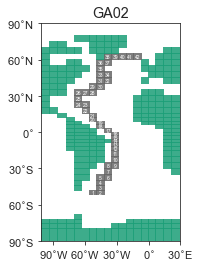

In [9]:
# plot trajectory on Bern3D grid (using functions.py which uses plot_gruber.py)

##################### SETTINGS ######################################################
cruise = 'GA02'  # pick from: 'GA02','GAc02','GA03','GA10','GIPY04','GIPY05','GIpr05','GP16','GPc01','GSc02','deng','ng','pavia'
verbose = True   # prints lon/lat coordinates
##################### END OF SETTINGS ###############################################

basic_data_trajectory = [data_fulls[runs[0]], t, model_coords_per_cruise, cmap] # preparation; run only used for grid

fig = f.generate_trajectory_fig(cruise=cruise, basic_data=basic_data_trajectory, verbose=verbose)

# plt.savefig(savedir / ('map_' + cruise + '.pdf'))

# Section/transect plots

run: 3P5_CTRL__
cruise: GA02


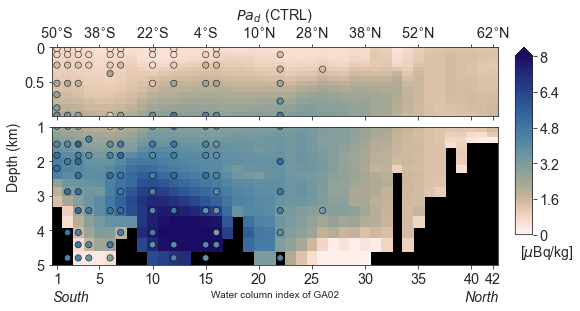

In [10]:
# section plot: 1 panel (using functions.py which uses plot_gruber.py)

##################### SETTINGS ######################################################
run = best_3P5_ctrl
cruise = 'GA02'       # pick from: 'GA02','GAc02','GA03','GA10','GIPY04','GIPY05','GIpr05','GP16','GPc01','GSc02','deng','ng','pavia'
variable = 'Pad_Bq'   # see vmaxs keys for options

cmap = cmcr.lapaz_r
this_vmin = 0.0
vmaxs = {'Pad_Bq' : 8, 'Thd_Bq' : 25, 'Pap_Bq' : 0.2, 'Thp_Bq' : 2,
         'path_ratio_d' : 1, 'path_ratio_p' : 0.2}
# vmaxs = {'Pad_Bq' : 40, 'Thd_Bq' : 25, 'Pap_Bq' : 0.2, 'Thp_Bq' : 2,
#          'path_ratio_d' : 1, 'path_ratio_p' : 0.2}
obs = True         # plot observations in circles on top of model output
verbose = False    # for debugging
##################### END OF SETTINGS ###############################################
print('run:', run)
print('cruise:', cruise)

basic_data_section = [t, model_coords_per_cruise, cmap, obs_d_ave, obs_p_ave]
var_label = {'Pad' : '$Pa_d$', 'Pap' : '$Pa_p$', 'Thd' : '$Th_d$', 'Thp' : '$Th_p$',
             'Pad_Bq' : '$Pa_d$', 'Pap_Bq' : '$Pa_p$', 'Thd_Bq' : '$Th_d$', 'Thp_Bq' : '$Th_p$',
             'path_ratio_p' : '$Pa_p/Th_p$', 'path_ratio_d' : 'Pa_d/Th_d'}
this_title = var_label[variable]+' ('+labels[run]+')'

fig = f.generate_1_section_plot_fig(dataset=data_fulls[run], variable=variable, title=this_title,
                                    cruise=cruise, basic_data=basic_data_section, this_vmin=this_vmin, 
                                    vmaxs=vmaxs, obs=obs, verbose=verbose)

plt.savefig(savedir / (cruise + '_' + run + '_' + variable + '.pdf'))

# Fig. 5, C1: combine multiple section/transect plots with pdfjam 
#### Why is combining pdfs (pdfjam) needed?
- We want to combine multiple plots i.e. panels for multiple variables and/or runs and/or trajectories.
- With the current plotting routines, 1 section plot (as above) already consists of multiple subplots, so we cannot simply use subplots.  
- Therefore we use pdfjam to combine the pdfs generated of each desired section plot/'subpanel'.  

#### How to install pdfjam:
- Check if you already have it / installation succeeded via '$ which pdfjam'  
- Linux (Ubuntu): '$ sudo apt-get install pdfjam'
- OS X when using macports: '$ sudo port install pdfjam'
- Otherwise on OS X or linux: follow https://www.ctan.org/tex-archive/support/pdfjam/#install

Now go ahead and execute the desired figures in this notebook.  
The notebook already calls pdfjam followed by pdfCropMargins to cut away white border. No additional steps are needed.   

#### How to view the resulting figures?
- The previews in this notebook never show the result correctly
- But it looks nice when you **open the resulting pdf to see the layout**
- This also shows you whether the result is correct (wrong if still multiple pages or large white border)
- The first printed output tells you the filename of the resulting pdf and intermediate results (before cropping).

**For 1 cruise (and run) of choice**

run: 3P5_CTRL__
cruise: GA03

Figure will be saved as figures/GA03_all_3P5_CTRL__.pdf
Uncropped version as     figures/GA03_all_3P5_CTRL___uncropped.pdf
Half-cropped version as figures/GA03_all_3P5_CTRL___halfcropped.pdf


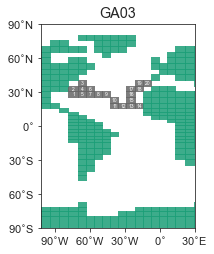

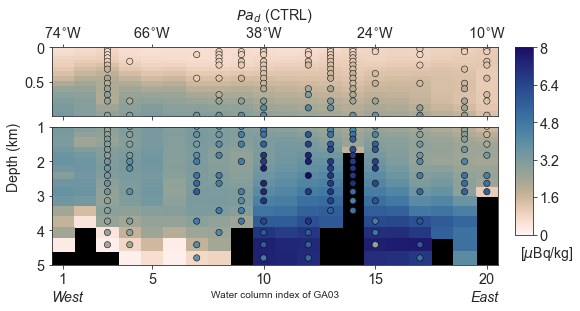

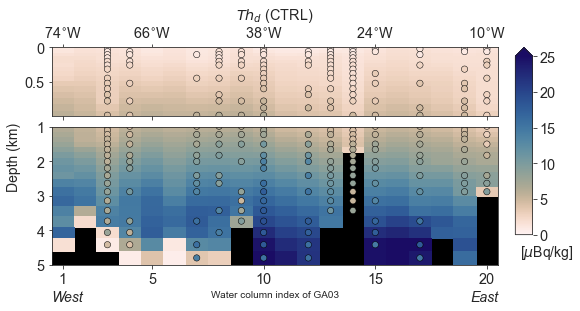

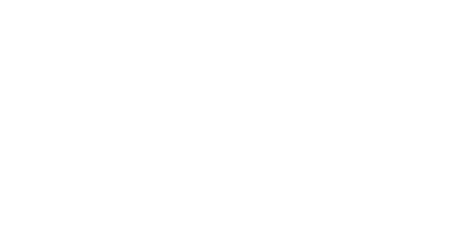

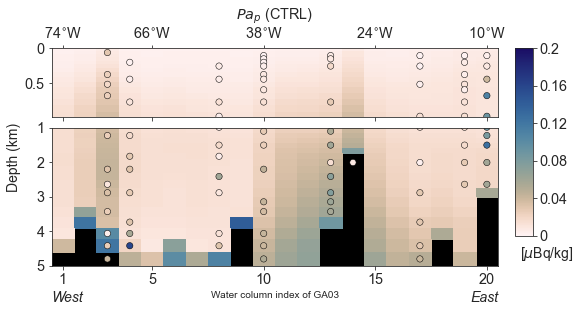

In [11]:
## FIRST COMBINE ALL PLOTS INCL. TRAJECTORY MAP FOR 1 CRUISE 

########################## SETTINGS ############################################
run = best_3P5_ctrl
this_cruise = 'GA03'

out_file_name = str(savedir / (this_cruise + '_all_' + run))  # without .pdf
cmap = cmcr.lapaz_r
this_vmin = 0.0
vmaxs = {'Pad_Bq' : 8, 'Thd_Bq' : 25, 'Pap_Bq' : 0.2, 'Thp_Bq' : 2,
         'path_ratio_d' : 1, 'path_ratio_p' : 0.2}
################################################################################
print('run:', run)
print('cruise:', this_cruise)
print('\nFigure will be saved as', out_file_name+'.pdf')
print('Uncropped version as    ', out_file_name+'_uncropped.pdf')
print('Half-cropped version as', out_file_name+'_halfcropped.pdf')

basic_data_section = [t, model_coords_per_cruise, cmap, obs_d_ave, obs_p_ave]
basic_data_trajectory = [data_fulls[run], t, model_coords_per_cruise, cmap]
var_label = {'Pad' : '$Pa_d$', 'Pap' : '$Pa_p$', 'Thd' : '$Th_d$', 'Thp' : '$Th_p$',
             'Pad_Bq' : '$Pa_d$', 'Pap_Bq' : '$Pa_p$', 'Thd_Bq' : '$Th_d$', 'Thp_Bq' : '$Th_p$',
             'path_ratio_p' : '$Pa_p/Th_p$', 'path_ratio_d' : 'Pa_d/Th_d'}

if this_cruise in ['GA03', 'GIPY04', 'GIPY05', 'GN01', 'GP16']:  # particle-bound obs. available
    p_available = True
    cruise_vars = ['Pad_Bq', 'Thd_Bq', 'Pap_Bq', 'Thp_Bq']
else:
    p_available = False
    cruise_vars = ['Pad_Bq', 'Thd_Bq']

with PdfPages(out_file_name+'_uncropped.pdf') as pdf:
    
    ## A). first generate trajectory map for this cruise WITH whitespace on the left (once)

    # temporarily change global parameter to NOT cut off whitespace
    matplotlib.rcParams['savefig.bbox'] = 'standard'

    fig = f.generate_trajectory_fig(cruise=this_cruise, basic_data=basic_data_trajectory)

    # overwriting the (2.5,4) for Atlantic zoom to (8,4) + extra width for cbar in transect plot:
    fig.set_size_inches(8.134,4)
    # start subplot rectangle at left=68.75% of width s.t. same ratio stays the same(5.5/8=0.6875); others s.t. align with transect plot
    plt.subplots_adjust(left=0.6875, right=0.95, top=0.858, bottom=0.15)

    pdf.savefig()

    # set back global parameter as desired in the rest of the notebook
    matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace

    if p_available:
        # save figure size of map
        map_width, map_height = fig.get_size_inches()
    
    ## B). then plot section for dissolved
    for this_var in ['Pad_Bq', 'Thd_Bq']:
        this_title = var_label[this_var]+' ('+labels[run]+')'
        fig = f.generate_1_section_plot_fig(dataset=data_fulls[run], variable=this_var, title=this_title,
                                            cruise=this_cruise, basic_data=basic_data_section, 
                                            this_vmin=this_vmin, vmaxs=vmaxs)
        pdf.savefig(bbox_inches='tight')
        
    if p_available:
        ## C). create 1 empty map figure to align
        fig, ax = plt.subplots(1,figsize=(map_width, map_height))
        ax.set_axis_off()
        pdf.savefig(fig)

        ## D). then plot section for particle-bound
        for this_var in ['Pap_Bq', 'Thp_Bq']:
            this_title = var_label[this_var]+' ('+labels[run]+')'
            fig = f.generate_1_section_plot_fig(dataset=data_fulls[run], variable=this_var, title=this_title,
                                                cruise=this_cruise, basic_data=basic_data_section, 
                                                this_vmin=this_vmin, vmaxs=vmaxs, avoid_negative=True)
            pdf.savefig(bbox_inches='tight')

## COMBINE SUBPLOTS INTO 1 PAGE WITH pdfjam
pdf_jam_location = !which pdfjam
if pdf_jam_location[0].find('not found') != -1:
   raise Exception("ERROR: pdfjam not found. Please install pdfjam (see installation instructions above).")

if p_available:
    os.system('pdfjam --nup 3x2 '+out_file_name+'_uncropped.pdf --outfile '+out_file_name+'_uncropped.pdf')
else:
    os.system('pdfjam --nup 3x1 '+out_file_name+'_uncropped.pdf --outfile '+out_file_name+'_uncropped.pdf')

# for some reason using the settings '--pagetemplate=2' or '--templatesize={8}{4}' in pdfjam 
#      [see PDFpages manual from here: https://github.com/rrthomas/pdfjam#using
# did not work to combine and rescale them as I want. That is why I found the hacky solution with extra whitespace in the map

## CROP AWAY WHITE BORDER WITH pdfCropMargins
# I am using python package pdfCropMargins ('from pdfCropMargins import crop' is at top of notebook). 
# Alternative: command line tool pdfjam, but I didn't get its dependencies to work on OS X. Syntax would be:
# os.system('pdfcrop '+out_file_name+'.pdf '+out_file_name+'.pdf')

# crop twice
crop([out_file_name+"_uncropped.pdf", "--outfile", out_file_name+"_halfcropped.pdf"])
crop([out_file_name+"_halfcropped.pdf", "--outfile", out_file_name+".pdf"])
# python syntax: https://github.com/abarker/pdfCropMargins#python-interface
# documentation of flags: https://github.com/abarker/pdfCropMargins#documentation

plt.close()

**Fig. 5 (Atl selected cruises) and C1 (Atl other cruises)**

run: 3P5_CTRL__
cruise list: ['GA02', 'GA03']

Figure will be saved as figures/fig5_Atl_selected_cruises_3P5_CTRL__.pdf
Uncropped version as     figures/fig5_Atl_selected_cruises_3P5_CTRL___uncropped.pdf
Half-cropped version as figures/fig5_Atl_selected_cruises_3P5_CTRL___halfcropped.pdf


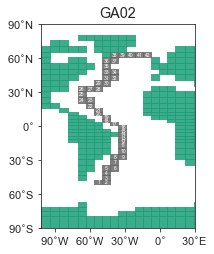

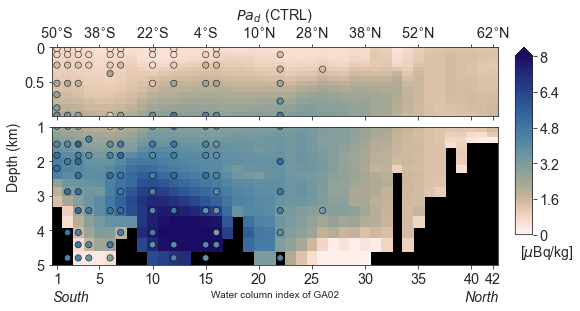

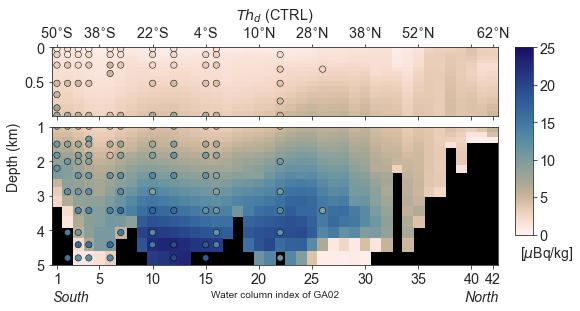

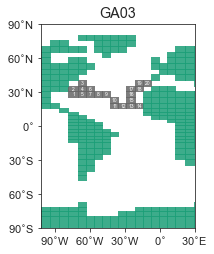

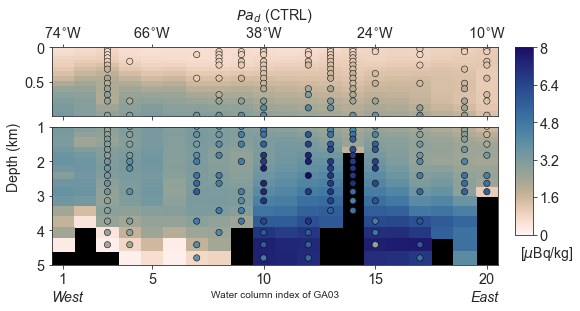

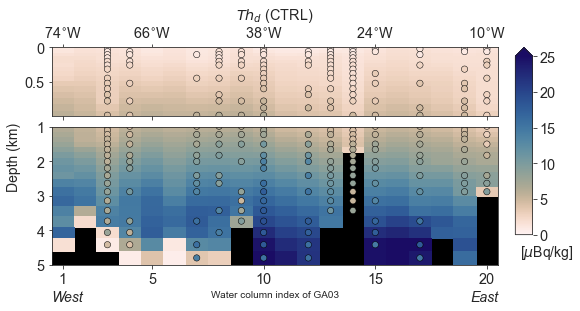

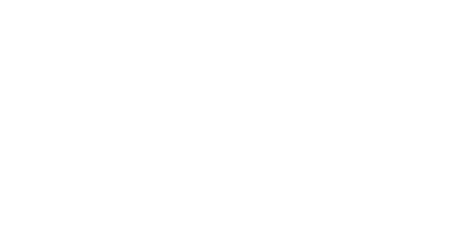

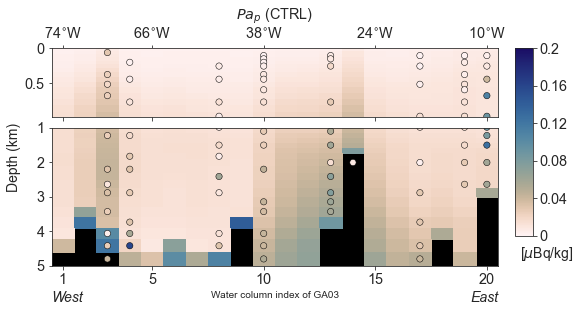

In [16]:
## COMBINE ALL PLOTS FOR ENTIRE ATLANTIC OR PACIFIC
# usually we exclude ng and GAc02 since they only have a few stations (can be changed in cruise_list setting)

########################## SETTINGS ############################################
run = best_3P5_ctrl
# fill in/comment in the desired cruise_list below

cmap = cmcr.lapaz_r
this_vmin = 0.0
vmaxs = {'Pad_Bq' : 8, 'Thd_Bq' : 25, 'Pap_Bq' : 0.2, 'Thp_Bq' : 2,
         'path_ratio_d' : 1, 'path_ratio_p' : 0.2}

###################### COMMENT IN WHICH FIGURE YOU WANT (COMMENT OUT REST): #####

    ############## FIGURE 5 ################
## most interesting Atl cruises:
cruise_list = ['GA02', 'GA03']
out_file_name = str(savedir / ('fig5_Atl_selected_cruises_' + run))

    ############## FIGURE C1 ################
# ## other Atl cruises:
# cruise_list = ['deng', 'GA10', 'GIPY04', 'GIPY05']
# out_file_name = str(savedir / ('figC1_Atl_other_cruises_' + run))

    ######## OTHER SETS TO PLAY AROUND ######
# # all Atl cruises (figure too long for 1 A4):
# cruise_list = ['GA02', 'GA03', 'deng', 'GA10', 'GIPY04', 'GIPY05']
# out_file_name = str(savedir / ('Atl_all_cruises_' + run))  # without .pdf

## Atl cruises w/o SO sector:
# cruise_list = ['GA02', 'GA03', 'deng', 'GA10']
# out_file_name = str(savedir / ('Atl_all_cruises_wo_SO_' + run))

## cruises in Atl. SO sector:
# cruise_list = ['GIPY04', 'GIPY05']
# out_file_name = str(savedir / ('Atl_only_SO_cruises_' + run))

## Pac cruises all w/o SO sector:
# cruise_list = ['GP16', 'GIpr05', 'GPc01', 'GSc02', 'pavia']
# out_file_name = str(savedir / ('Pac_all_cruises_' + run))

## Pac cruises interesting w/o SO sector:
# cruise_list = ['GP16', 'GPc01', 'GSc02']
# out_file_name = str(savedir / ('Pac_selected_cruises_' + run))

#################################################################################
print('run:', run)
print('cruise list:', cruise_list)
print('\nFigure will be saved as', out_file_name+'.pdf')
print('Uncropped version as    ', out_file_name+'_uncropped.pdf')
print('Half-cropped version as', out_file_name+'_halfcropped.pdf')

basic_data_section = [t, model_coords_per_cruise, cmap, obs_d_ave, obs_p_ave]
basic_data_trajectory = [data_fulls[run], t, model_coords_per_cruise, cmap]
var_label = {'Pad' : '$Pa_d$', 'Pap' : '$Pa_p$', 'Thd' : '$Th_d$', 'Thp' : '$Th_p$',
             'Pad_Bq' : '$Pa_d$', 'Pap_Bq' : '$Pa_p$', 'Thd_Bq' : '$Th_d$', 'Thp_Bq' : '$Th_p$',
             'path_ratio_p' : '$Pa_p/Th_p$', 'path_ratio_d' : 'Pa_d/Th_d'}

nr_rows_counter = 0
with PdfPages(out_file_name+'_uncropped.pdf') as pdf:
    for this_cruise in cruise_list:
        if this_cruise in ['GA03', 'GIPY04', 'GIPY05', 'GN01', 'GP16']:  # particle-bound obs. available
            p_available = True
            cruise_vars = ['Pad_Bq', 'Thd_Bq', 'Pap_Bq', 'Thp_Bq']
            nr_rows_counter += 2
        else:
            p_available = False
            cruise_vars = ['Pad_Bq', 'Thd_Bq']
            nr_rows_counter += 1

        ## A). first generate trajectory map for this cruise WITH whitespace on the left (once)

        # temporarily change global parameter to NOT cut off whitespace
        matplotlib.rcParams['savefig.bbox'] = 'standard'

        fig = f.generate_trajectory_fig(cruise=this_cruise, basic_data=basic_data_trajectory)

        # overwriting the (2.5,4) for Atlantic zoom to (8,4) + extra width for cbar in transect plot:
        fig.set_size_inches(8.134,4)
        # start subplot rectangle at left=68.75% of width s.t. same ratio stays the same(5.5/8=0.6875); others s.t. align with transect plot
        plt.subplots_adjust(left=0.6875, right=0.95, top=0.858, bottom=0.15)

        pdf.savefig()

        # set back global parameter as desired in the rest of the notebook
        matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace

        if p_available:
            # save figure size of map to use below
            map_width, map_height = fig.get_size_inches()

        ## B). then plot section for dissolved
        for this_var in ['Pad_Bq', 'Thd_Bq']:
            this_title = var_label[this_var]+' ('+labels[run]+')'
            fig = f.generate_1_section_plot_fig(dataset=data_fulls[run], variable=this_var, title=this_title,
                                                cruise=this_cruise, basic_data=basic_data_section, 
                                                this_vmin=this_vmin, vmaxs=vmaxs)
            pdf.savefig(bbox_inches='tight')

        ## if particle-bound available: create a 2nd row for this cruise
        if p_available:
            ## C). create 1 empty map figure to align
            fig, ax = plt.subplots(1,figsize=(map_width, map_height))
            ax.set_axis_off()
            pdf.savefig(fig)

            ## D). then plot section for particle-bound
            for this_var in ['Pap_Bq', 'Thp_Bq']:
                this_title = var_label[this_var]+' ('+labels[run]+')'
                fig = f.generate_1_section_plot_fig(dataset=data_fulls[run], variable=this_var, title=this_title,
                                                    cruise=this_cruise, basic_data=basic_data_section, 
                                                    this_vmin=this_vmin, vmaxs=vmaxs, avoid_negative=True)
                pdf.savefig(bbox_inches='tight')

## COMBINE SUBPLOTS INTO 1 PAGE WITH pdfjam
pdf_jam_location = !which pdfjam
if pdf_jam_location[0].find('not found') != -1:
   raise Exception("ERROR: pdfjam not found. Please install pdfjam (see installation instructions above).")

os.system('pdfjam --nup 3x'+str(nr_rows_counter)+' '+out_file_name+'_uncropped.pdf --outfile '+out_file_name+'_uncropped.pdf')

# for some reason using the settings '--pagetemplate=2' or '--templatesize={8}{4}' in pdfjam 
#      [see PDFpages manual from here: https://github.com/rrthomas/pdfjam#using
# did not work to combine and rescale them as I want. That is why I found the hacky solution with extra whitespace in the map

## CROP AWAY WHITE BORDER WITH pdfCropMargins
# I am using python package pdfCropMargins ('from pdfCropMargins import crop' is at top of notebook). 
# Alternative: command line tool pdfjam, but I didn't get its dependencies to work on OS X. Syntax would be:
# os.system('pdfcrop '+out_file_name+'.pdf '+out_file_name+'.pdf')

# crop twice
crop([out_file_name+"_uncropped.pdf", "--outfile", out_file_name+"_halfcropped.pdf"])
crop([out_file_name+"_halfcropped.pdf", "--outfile", out_file_name+".pdf"])
# python syntax: https://github.com/abarker/pdfCropMargins#python-interface
# documentation of flags: https://github.com/abarker/pdfCropMargins#documentation

plt.close()

# Fig. 11: sensitivity

cruise list: ['GA02', 'GA03']

Figure will be saved as figures/fig11_Atl_cruises_p_sensitivity_orig.pdf
Uncropped version as     figures/fig11_Atl_cruises_p_sensitivity_orig_uncropped.pdf
Half-cropped version as figures/fig11_Atl_cruises_p_sensitivity_orig_halfcropped.pdf


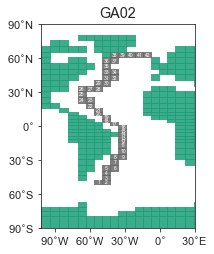

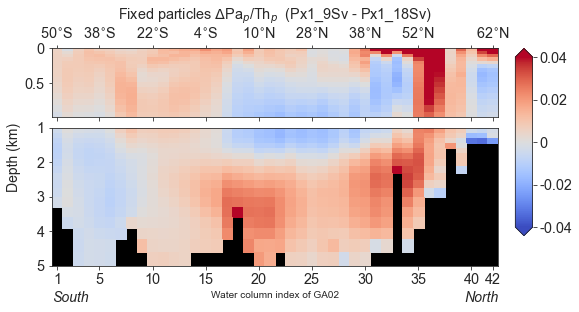

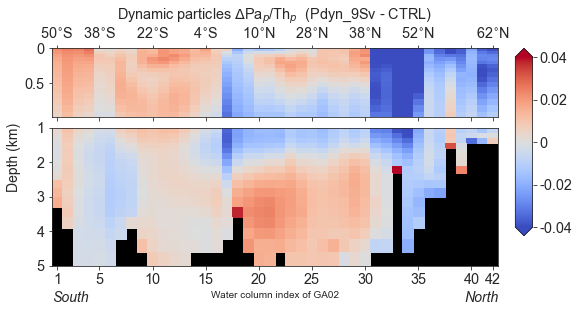

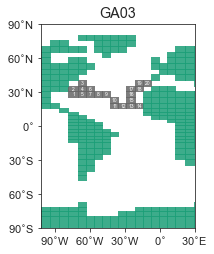

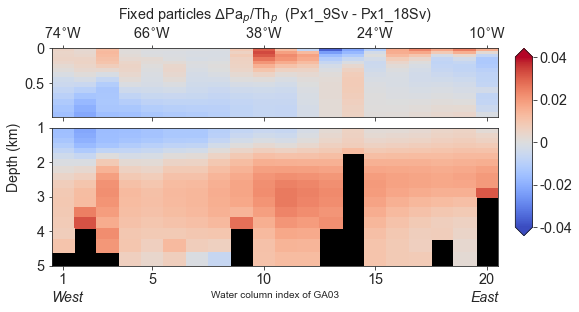

In [13]:
# sensitivity plot along transects GA02 and GA03

#### SETTINGS ########################################
# runs are set below in runs_per_column
cruise_list = ['GA02', 'GA03']  # most interesting Atl cruises
# cruise_list = ['GA02']        # fewer

out_file_name = str(savedir / ('fig11_Atl_cruises_p_sensitivity_orig'))  # without .pdf; 'orig' because will annotate regions later in ppt
cmap = cmp.coolwarm # cmcr.vik # diverging for anomaly
vmaxs = {'Pad_Bq' : 8, 'Thd_Bq' : 25, 'Pap_Bq' : 0.2, 'Thp_Bq' : 2,
         'path_ratio_d' : 1, 'path_ratio_p' : 0.04}  # only path_ratio_p adjusted yet for anoms
vmins = {'Pad_Bq' : -vmaxs['Pad_Bq'], 'Thd_Bq' : -vmaxs['Thd_Bq'], 'Pap_Bq' : -vmaxs['Pap_Bq'], 'Thp_Bq' : -vmaxs['Thp_Bq'],
         'path_ratio_d' : -vmaxs['path_ratio_d'], 'path_ratio_p' : -vmaxs['path_ratio_p']}
levels = 8  # because 2 levels between ticks
#### END OF SETTINGS ################################
print('cruise list:', cruise_list)
print('\nFigure will be saved as', out_file_name+'.pdf')
print('Uncropped version as    ', out_file_name+'_uncropped.pdf')
print('Half-cropped version as', out_file_name+'_halfcropped.pdf')

this_var = 'path_ratio_p'
runs_per_column = [[PFX1__09SV, particles_ctrl_yesneph],
                   [PFREE_09SV, best_3P5_ctrl]]
labels_per_column = ['Fixed particles $\Delta$Pa$_p$/Th$_p$',
                     'Dynamic particles $\Delta$Pa$_p$/Th$_p$'] 

basic_data_section = [t, model_coords_per_cruise, cmap, obs_d_ave, obs_p_ave]
basic_data_trajectory = [data_fulls[run], t, model_coords_per_cruise, cmap]  # stick to 1 run's dataset because uses mask
var_label = {'Pad' : '$Pa_d$', 'Pap' : '$Pa_p$', 'Thd' : '$Th_d$', 'Thp' : '$Th_p$',
             'Pad_Bq' : '$Pa_d$', 'Pap_Bq' : '$Pa_p$', 'Thd_Bq' : '$Th_d$', 'Thp_Bq' : '$Th_p$',
             'path_ratio_p' : '$Pa_p/Th_p$', 'path_ratio_d' : 'Pa_d/Th_d'}

# make dataset run1 minus run2
vars_to_keep = ['Pad', 'Thd', 'Pap', 'Thp', 
                'Pad_Bq', 'Thd_Bq', 'Pap_Bq', 'Thp_Bq', 
                'path_ratio_p', 'path_ratio_d', 
                'lat_t','lon_t','lat_u','lon_u','z_t','z_w']

runs_diff = []
for col in [0,1]:
    runs_diff.append(f.drop_most_vars(data_fulls[runs_per_column[col][0]], vars_to_keep=vars_to_keep) - 
                     f.drop_most_vars(data_fulls[runs_per_column[col][1]], vars_to_keep=vars_to_keep))

nr_rows_counter = 0
with PdfPages(out_file_name+'_uncropped.pdf') as pdf:
    for this_cruise in cruise_list:
        nr_rows_counter += 1
        ## A). first generate trajectory map for this cruise WITH whitespace on the left (once)

        # temporarily change global parameter to NOT cut off whitespace
        matplotlib.rcParams['savefig.bbox'] = 'standard'

        fig = f.generate_trajectory_fig(cruise=this_cruise, basic_data=basic_data_trajectory)

        # overwriting the (2.5,4) for Atlantic zoom to (8,4) + extra width for cbar in transect plot:
        fig.set_size_inches(8.134,4)
        # start subplot rectangle at left=68.75% of width s.t. same ratio stays the same(5.5/8=0.6875); others s.t. align with transect plot
        plt.subplots_adjust(left=0.6875, right=0.95, top=0.858, bottom=0.15)
        
        pdf.savefig()

        # set back global parameter as desired in the rest of the notebook
        matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace

        ## B). & C.) plot Pa/Th ratio for column 1 (PI particles x1) and 2 (Dynamic particles)
        for col in [0,1]:
            title = labels_per_column[col] + '  (' + labels[runs_per_column[col][0]] + ' - ' + labels[runs_per_column[col][1]] + ')'
            fig = f.generate_1_section_plot_fig(dataset=runs_diff[col], variable=this_var, title=title,
                                                cruise=this_cruise, basic_data=basic_data_section, 
                                                this_vmin=vmins[this_var], vmaxs=vmaxs, levels=levels,
                                                # this_vmin=None, vmaxs={str(this_var) : None},  # to look at automatic range
                                                cbar_extend_both=True, obs=False) # force both cbar arrows because anomaly plot
            pdf.savefig(bbox_inches='tight')

## COMBINE SUBPLOTS INTO 1 PAGE WITH pdfjam
pdf_jam_location = !which pdfjam
if pdf_jam_location[0].find('not found') != -1:
   raise Exception("ERROR: pdfjam not found. Please install pdfjam (see installation instructions above).")

os.system('pdfjam --nup 3x'+str(nr_rows_counter)+' '+out_file_name+'_uncropped.pdf --outfile '+out_file_name+'_uncropped.pdf')

# for some reason using the settings '--pagetemplate=2' or '--templatesize={8}{4}' in pdfjam 
#      [see PDFpages manual from here: https://github.com/rrthomas/pdfjam#using]
# did not work to combine and rescale them as I want. That is why I found the hacky solution with extra whitespace in the map

## CROP AWAY WHITE BORDER WITH pdfCropMargins
# I am using python package pdfCropMargins ('from pdfCropMargins import crop' is at top of notebook). 
# Alternative: command line tool pdfjam, but I didn't get its dependencies to work on OS X. Syntax would be:
# os.system('pdfcrop '+out_file_name+'.pdf '+out_file_name+'.pdf')

# crop twice
crop([out_file_name+"_uncropped.pdf", "--outfile", out_file_name+"_halfcropped.pdf"])
crop([out_file_name+"_halfcropped.pdf", "--outfile", out_file_name+".pdf"])
# python syntax: https://github.com/abarker/pdfCropMargins#python-interface
# documentation of flags: https://github.com/abarker/pdfCropMargins#documentation

plt.close()

# NEED TO OPEN THE PDF (seems to miss 1 panel as seen from notebook but that is not the case)

timestep: t= -1 

Row 0 has runs:
PFX1__09SV with run label= Px1_9Sv
PARTX1NBGC with run label= Px1_18Sv 

Row 1 has runs:
PFREE_09SV with run label= Pdyn_9Sv
3P5_CTRL__ with run label= CTRL 



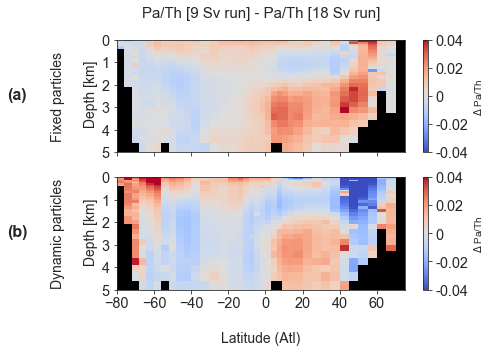

In [14]:
# sensitivity plot
# =====================================================
# VERSION: Atlantic zonal average (=OLD VERSION)
# =====================================================

##################### SETTINGS ######################################################
runs_per_row = [[PFX1__09SV, particles_ctrl_yesneph],[PFREE_09SV, best_3P5_ctrl]] # runs to take anomaly per row
# row_labels = ['PI particles x1', 'Dynamic particles']
row_labels = ['Fixed particles', 'Dynamic particles'] # fixed means fixed to PI distribution (x 1)
these_labels = {PFX1__09SV : "Px1_9Sv", particles_ctrl_yesneph : "Px1_18Sv", 
                PFREE_09SV : "Pdyn_9Sv", best_3P5_ctrl : "CTRL"}

rectangular = True  # make figure broader; more suitable for 16:9 slides
cmap = cmp.coolwarm # for anomaly
# output time step to plot
t=-1
# set colour scale boundaries for anom:
vmax = 0.04
vmin = -vmax
these_ticks = [-0.04,-0.02,0,0.02,0.04]
tick_labels = ["-0.04","-0.02","0","0.02","0.04"]
anom_free = False    # overwrites vmin, vmax
##################### END OF SETTINGS ###############################################

print("timestep: t=",t, '\n')
sns.set_style("ticks")
assert len(runs_per_row[0]) == 2, "Each row needs exactly 2 runs"
nr_rows = len(runs_per_row)

if rectangular:
    fig, ax = plt.subplots(nr_rows,1, figsize=(7,2.5*nr_rows))
else:
    fig, ax = plt.subplots(nr_rows,1, figsize=(6,3.5*nr_rows))

xlist = data_fulls[runs[0]].lat_u
ylist = data_fulls[runs[0]].z_w
X, Y = np.meshgrid(xlist, ylist)

# compute Atl Pa/Th averages (no anom yet)
ratio_obj = {}
for run in np.asarray(runs_per_row).flatten():
   obj = data_fulls[run]
   
   # particle-bound Atl average
   pap_global = f.model_to_sw_unit(obj.Pap.isel(time=t), obj.rho_SI.isel(time=t))
   thp_global = f.model_to_sw_unit(obj.Thp.isel(time=t), obj.rho_SI.isel(time=t))
   pap = pap_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True) 
   thp = thp_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True)        
   ratio_obj[run] = pap / thp             

# plot
for row,these_runs in enumerate(runs_per_row):
   print('Row',row,'has runs:')
   print(these_runs[0], 'with run label=', these_labels[these_runs[0]])
   print(these_runs[1], 'with run label=', these_labels[these_runs[1]], '\n')

   # particle-bound Atl average
   ratio = ratio_obj[these_runs[0]] - ratio_obj[these_runs[1]]

   if anom_free:
      cpf = ax[row].pcolormesh(X,Y,(ratio).values, cmap=cmap)
   else:
      cpf = ax[row].pcolormesh(X,Y,ratio.values, cmap=cmap, vmin=vmin, vmax=vmax)
   cbar = fig.colorbar(cpf, ax=ax[row], label="$\Delta$ Pa/Th", ticks=these_ticks)
   cbar.set_ticks(these_ticks)
   cbar.set_ticklabels(tick_labels)

   # ticks, labels
   ax[row].set_ylabel(row_labels[row] + "\n\n Depth [km]", fontsize=14)
   ax[row].invert_yaxis()
   ax[row].set_xlim(-80,75)
   ax[row].set_xticks(range(-80,65,20))
   ax[row].set_yticks(range(0,6))
   ax[row].set_facecolor('k')  # turn ocean topography black
   # ax[row].text(-0.25, 1.05, '(' + chr(ord('a')+row) + ')', transform=ax[row].transAxes, 
   #              size=16, weight='bold')
   ax[row].text(-0.38, 0.47, '(' + chr(ord('a')+row) + ')', transform=ax[row].transAxes, 
                size=16, weight='bold')
   # ax[row].set_title(these_labels[these_runs[0]] + " - " + these_labels[these_runs[1]], fontsize=14)

ax[0].set_title("Pa/Th [9 Sv run] - Pa/Th [18 Sv run]\n", fontsize=15)
ax[0].set_xticklabels([])
ax[nr_rows-1].set_xlabel('\nLatitude (Atl)', fontsize=14)

plt.tight_layout()
plt.savefig(savedir / ('Atl_avg_p_sensitivity.pdf'))